In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import statsmodels.api as sm

# Carregando os dados
df = pd.read_csv('Gastos_Publicidade_MelhoresCompras.csv')

# Exibindo as primeiras linhas e informações do DataFrame
print(df.head())
print(df.info())

    Ano  Mes  Tipo de Midia Gastos com Publicidade (em R$)  \
0  2022    1    Paginas web                          87000   
1  2022    1  Redes sociais                         120000   
2  2022    1             TV                         250000   
3  2022    1         Jornal                         110000   
4  2022    1        Revista                          40000   

   Previsao Inicial de Aumento de Vendas (em mil unidades)  
0                                               1000        
1                                                800        
2                                               1500        
3                                                730        
4                                                360        
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                                                   Non-Null Count  Dtype 
---  ------                                                   ----------

In [2]:
# Convertendo 'Gastos com Publicidade (em R$)' para numérico
df['Gastos com Publicidade (em R$)'] = df['Gastos com Publicidade (em R$)'].str.replace(',', '').astype(float)

# Criando variáveis dummy para 'Tipo de Midia'
df_dummy = pd.get_dummies(df['Tipo de Midia'], prefix='Midia')
df = pd.concat([df, df_dummy], axis=1)

# Criando colunas de gastos específicos para cada tipo de mídia
for midia in df_dummy.columns:
    df[f'Gastos_{midia}'] = df[midia] * df['Gastos com Publicidade (em R$)']

# Removendo colunas desnecessárias
df = df.drop(['Tipo de Midia', 'Gastos com Publicidade (em R$)'], axis=1)

print(df.head())
print(df.columns)

    Ano  Mes  Previsao Inicial de Aumento de Vendas (em mil unidades)  \
0  2022    1                                               1000         
1  2022    1                                                800         
2  2022    1                                               1500         
3  2022    1                                                730         
4  2022    1                                                360         

   Midia_Google  Midia_Instagram  Midia_Jornal  Midia_Paginas web  \
0         False            False         False               True   
1         False            False         False              False   
2         False            False         False              False   
3         False            False          True              False   
4         False            False         False              False   

   Midia_Radio  Midia_Redes sociais  Midia_Revista  Midia_TV  \
0        False                False          False     False   
1        False    

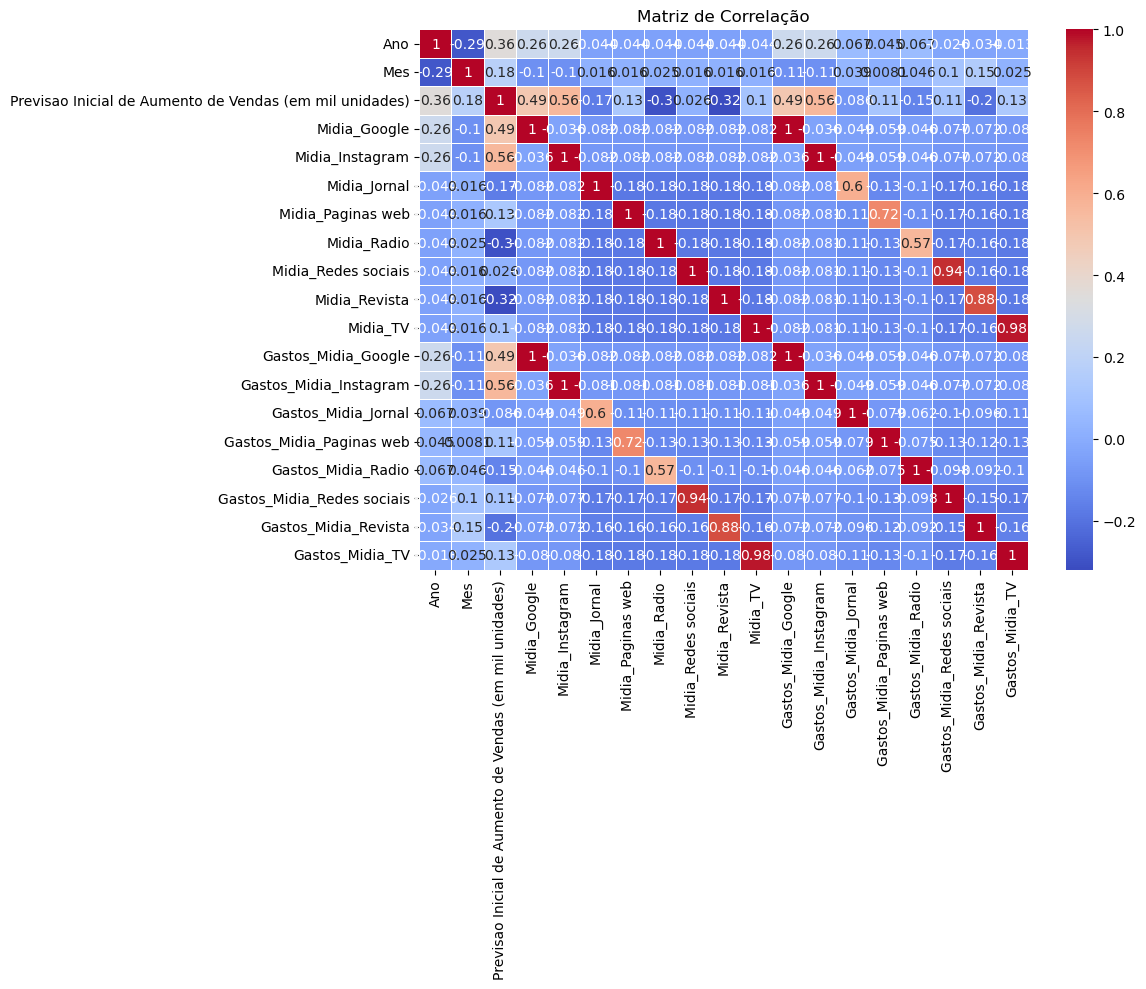

c:\Users\luish\anaconda3\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\luish\anaconda3\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\luish\anaconda3\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\luish\anaconda3\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dty

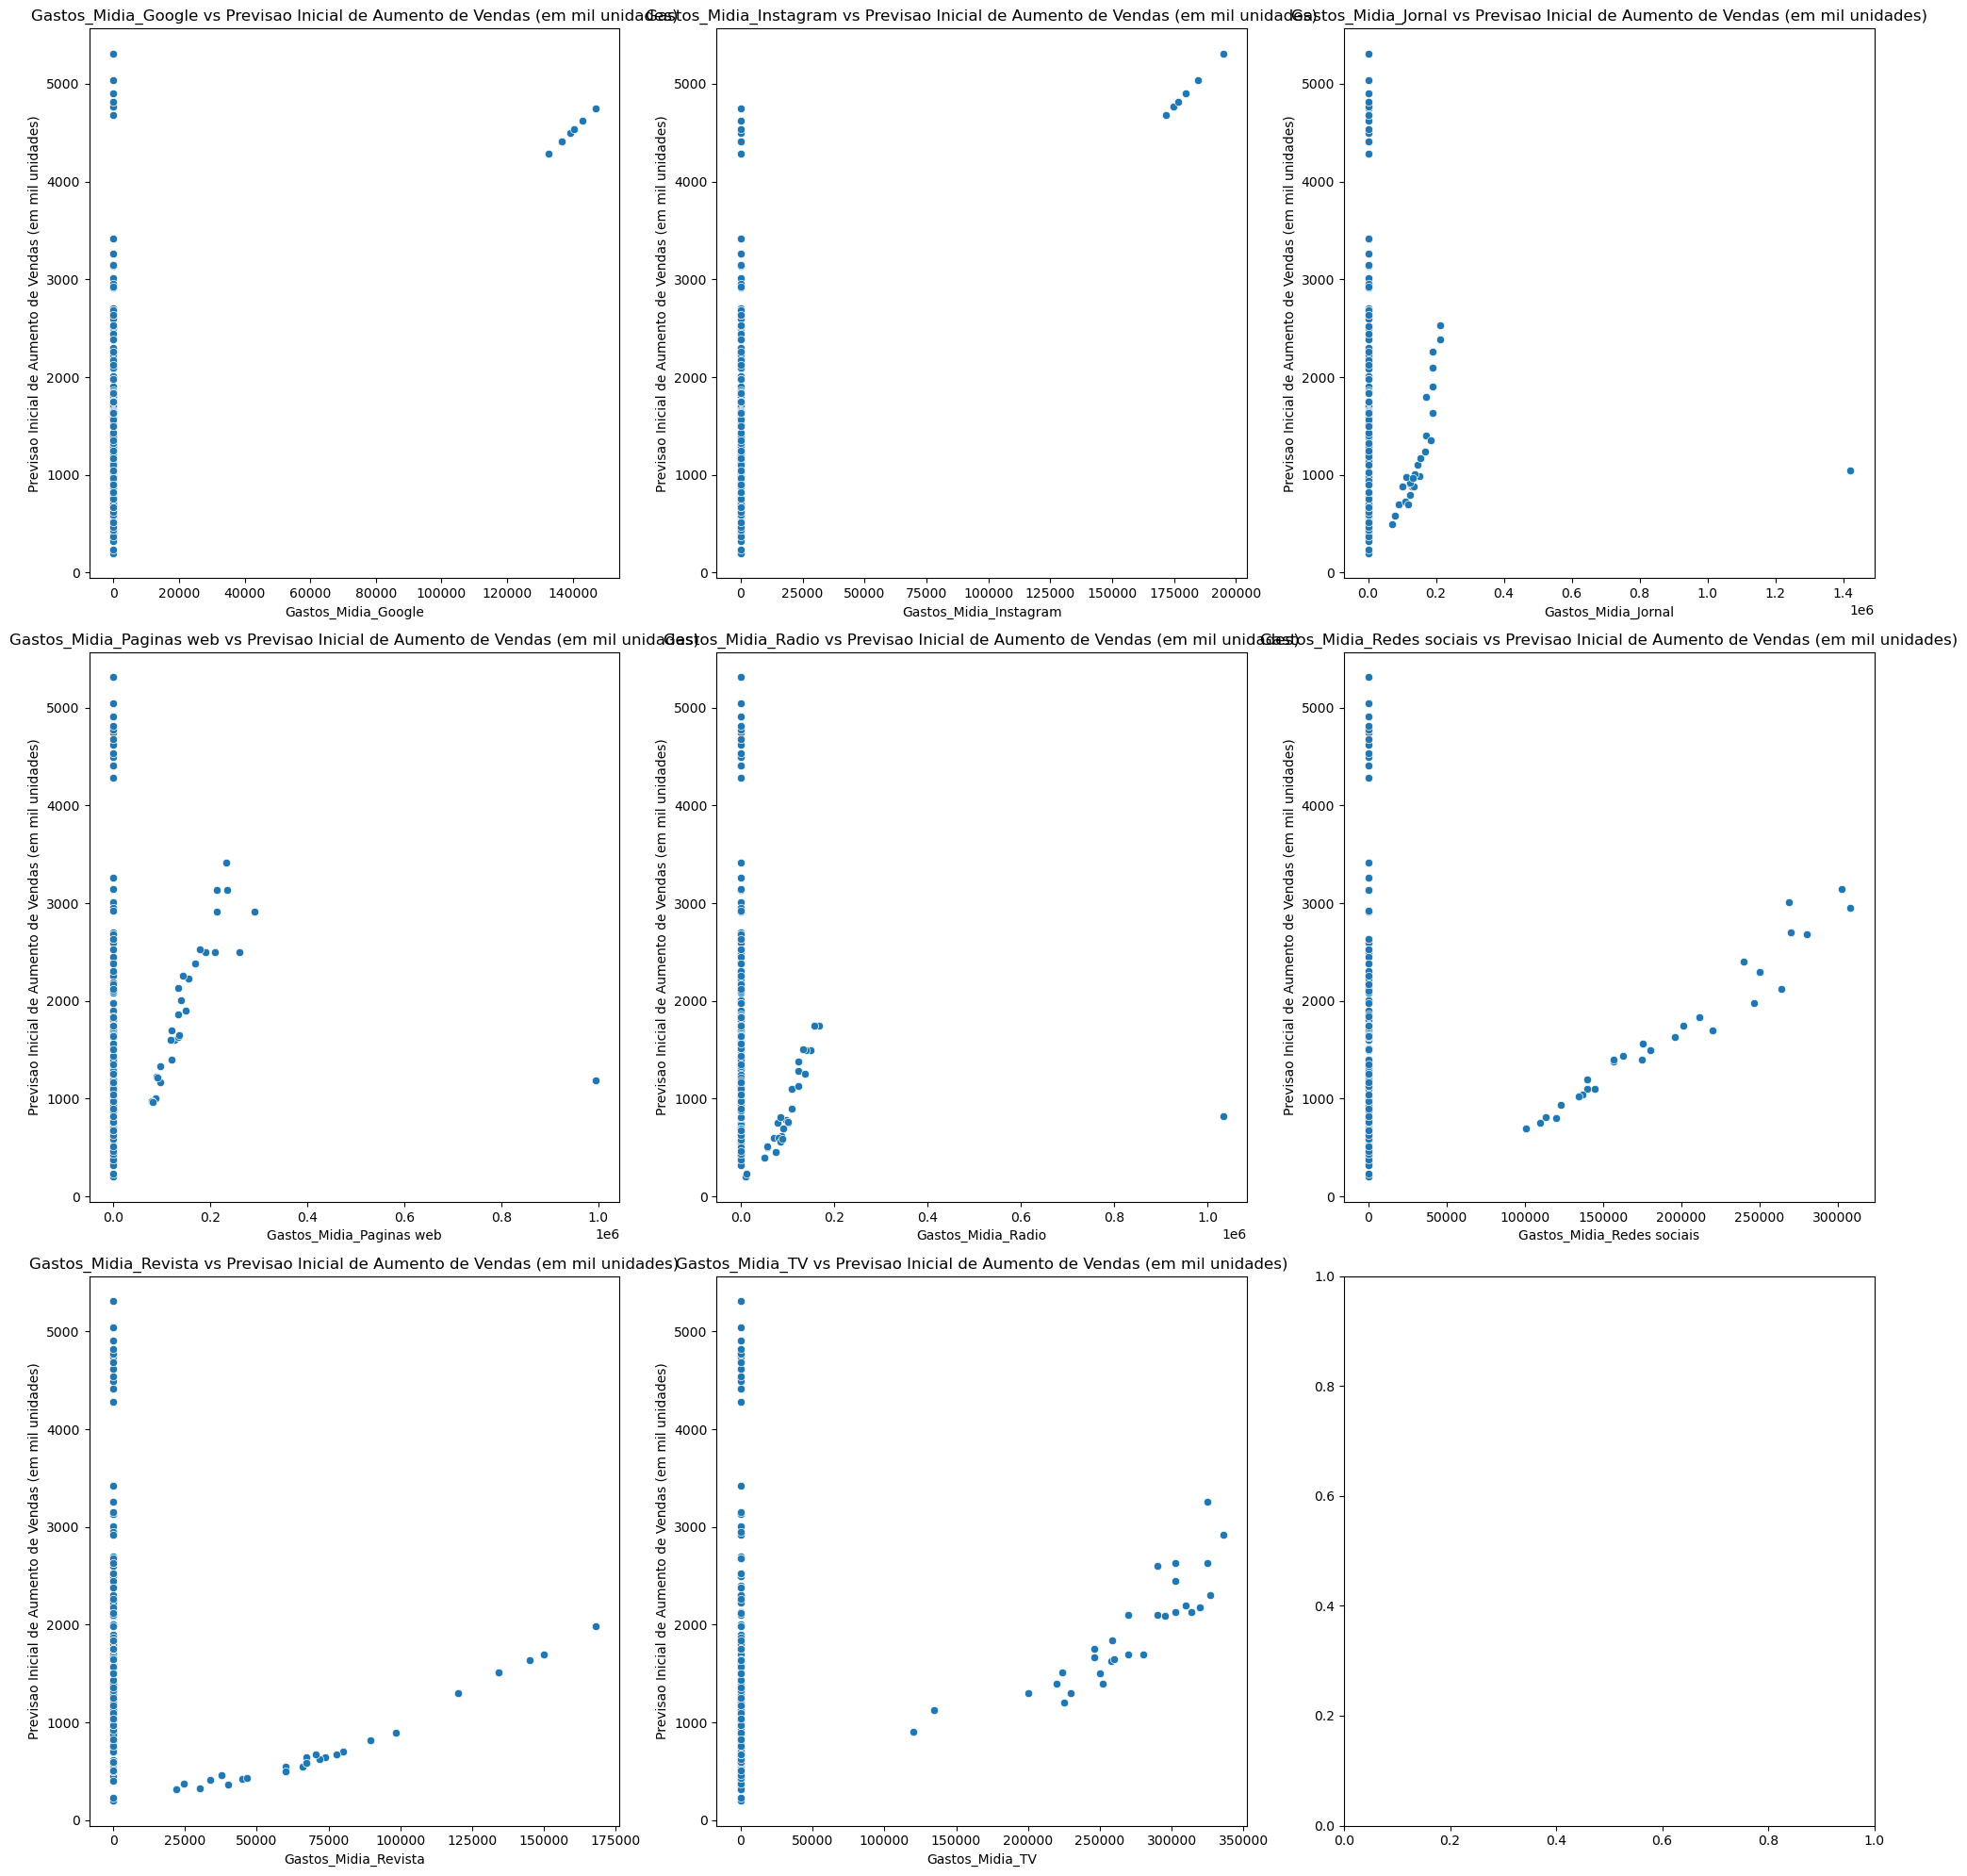

Comentários sobre a matriz de correlação:
1. As variáveis mais fortemente correlacionadas com o aumento de vendas são:
   - Gastos_Midia_Instagram: 0.56
   - Midia_Instagram: 0.56
   - Gastos_Midia_Google: 0.49
   - Midia_Google: 0.49
   - Ano: 0.36


In [3]:
# Matriz de correlação
correlation_matrix = df.corr()

# Plotando a matriz de correlação
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Matriz de Correlação')
plt.tight_layout()
plt.show()

# Gráficos de dispersão
target = 'Previsao Inicial de Aumento de Vendas (em mil unidades)'
features = [col for col in df.columns if col.startswith('Gastos_')]

fig, axes = plt.subplots(3, 3, figsize=(20, 20))
axes = axes.ravel()

for i, feature in enumerate(features):
    sns.scatterplot(data=df, x=feature, y=target, ax=axes[i])
    axes[i].set_title(f'{feature} vs {target}')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel(target)

plt.tight_layout()
plt.show()

# Comentários sobre a matriz de correlação
print("Comentários sobre a matriz de correlação:")
print("1. As variáveis mais fortemente correlacionadas com o aumento de vendas são:")
top_correlations = correlation_matrix[target].sort_values(ascending=False)[1:6]
for var, corr in top_correlations.items():
    print(f"   - {var}: {corr:.2f}")

In [5]:
"""
As variáveis mais fortemente correlacionadas com o aumento de vendas são:

Gastos_Midia_Instagram: 0.56
Midia_Instagram: 0.56
Gastos_Midia_Google: 0.49
Midia_Google: 0.49
Ano: 0.36


Observações interessantes:

Instagram e Google parecem ser os canais de mídia mais eficazes para aumentar as vendas, com correlações moderadas positivas.
Há uma correlação positiva fraca entre o ano e o aumento de vendas, sugerindo uma tendência de crescimento ao longo do tempo.
A maioria dos outros canais de mídia tem correlações fracas ou insignificantes com o aumento de vendas.
Existe uma forte correlação (próxima de 1.0) entre as variáveis dummy de mídia e seus respectivos gastos, o que é esperado e indica que não devemos usar ambas no mesmo modelo para evitar multicolinearidade.



Comentários sobre os gráficos de dispersão:

Gastos_Midia_Instagram e Gastos_Midia_Google mostram uma tendência positiva clara em relação ao aumento de vendas, corroborando com as correlações observadas na matriz.
Gastos_Midia_Redes_sociais também apresenta uma tendência positiva, embora com mais dispersão do que Instagram e Google.
Gastos_Midia_TV mostra uma relação positiva com o aumento de vendas, mas com maior variabilidade, especialmente para gastos mais altos.
Gastos_Midia_Jornal, Gastos_Midia_Paginas_web e Gastos_Midia_Radio parecem ter relações mais fracas ou não lineares com o aumento de vendas.
Gastos_Midia_Revista apresenta uma relação positiva fraca, com muitos pontos concentrados em gastos baixos.
Em geral, observa-se que a maioria dos canais de mídia tem algum impacto positivo nas vendas, mas a eficácia varia significativamente entre eles.

Estas observações nos dão insights valiosos para construir nosso modelo de regressão linear. Parece que focar em Instagram e Google pode ser uma estratégia eficaz, mas também devemos considerar outros canais que mostram alguma relação positiva com as vendas.
"""

''

In [4]:
# Preparando os dados para o modelo
X = df[['Ano', 'Mes', 'Gastos_Midia_Google', 'Gastos_Midia_Instagram', 
        'Gastos_Midia_Jornal', 'Gastos_Midia_Paginas web', 'Gastos_Midia_Radio',
        'Gastos_Midia_Redes sociais', 'Gastos_Midia_Revista', 'Gastos_Midia_TV']]
y = df['Previsao Inicial de Aumento de Vendas (em mil unidades)']

# Dividindo os dados em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Criando e treinando o modelo
model = LinearRegression()
model.fit(X_train, y_train)

# Fazendo previsões e calculando o R²
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)

print(f"R² do modelo: {r2:.4f}")

# Coeficientes do modelo
coef_df = pd.DataFrame({'Variável': X.columns, 'Coeficiente': model.coef_})
print("\nCoeficientes do modelo:")
print(coef_df.sort_values('Coeficiente', ascending=False))

# Sumário estatístico usando statsmodels
X_train_sm = sm.add_constant(X_train)
model_sm = sm.OLS(y_train, X_train_sm).fit()
print(model_sm.summary())

R² do modelo: 0.8404

Coeficientes do modelo:
                     Variável  Coeficiente
0                         Ano   220.947552
1                         Mes   105.609379
2         Gastos_Midia_Google     0.023975
3      Gastos_Midia_Instagram     0.020536
7  Gastos_Midia_Redes sociais     0.003417
9             Gastos_Midia_TV     0.003089
5    Gastos_Midia_Paginas web     0.002306
4         Gastos_Midia_Jornal     0.000071
6          Gastos_Midia_Radio    -0.000742
8        Gastos_Midia_Revista    -0.001270
                                               OLS Regression Results                                              
Dep. Variable:     Previsao Inicial de Aumento de Vendas (em mil unidades)   R-squared:                       0.833
Model:                                                                 OLS   Adj. R-squared:                  0.822
Method:                                                      Least Squares   F-statistic:                     74.56
Date:            

c:\Users\luish\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\luish\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():


In [ ]:
"""
Qualidade do modelo:

O R² do modelo é 0.8404, o que significa que nosso modelo explica aproximadamente 84.04% da variância nas vendas. Isso é um bom resultado, indicando que o modelo tem um poder preditivo relativamente alto.


Coeficientes mais significativos:
a) Ano (220.95) e Mês (105.61): Há uma tendência crescente nas vendas ao longo do tempo.
b) Gastos_Midia_Google (0.024) e Gastos_Midia_Instagram (0.021): Estes têm os maiores coeficientes positivos entre os canais de mídia, indicando que são os mais eficazes para aumentar as vendas.
c) Gastos_Midia_Redes_sociais (0.0034) e Gastos_Midia_TV (0.0031): Também têm impacto positivo, embora menor que Google e Instagram.
Canais menos eficazes:

Gastos_Midia_Radio e Gastos_Midia_Revista têm coeficientes negativos, sugerindo que podem não ser eficazes ou até contraproducentes.
Gastos_Midia_Jornal tem um coeficiente muito próximo de zero, indicando pouco impacto nas vendas.


Significância estatística:

A maioria das variáveis é estatisticamente significativa (p-valor < 0.05), exceto Gastos_Midia_Jornal, Gastos_Midia_Radio e Gastos_Midia_Revista.


Multicolinearidade:

O modelo alerta para possível multicolinearidade (Cond. No. alto), o que pode afetar a interpretação dos coeficientes individuais.



Recomendações para a equipe de marketing:

Foco em mídias digitais: Priorizar investimentos em Google e Instagram, pois estes canais mostram o maior retorno sobre o investimento (ROI).
Expansão em redes sociais: Além do Instagram, outras redes sociais também mostram um impacto positivo, então considerar aumentar a presença nestes canais.
Televisão ainda é relevante: Embora menos impactante que as mídias digitais, a TV ainda mostra um retorno positivo e pode ser importante para alcançar certos segmentos de público.
Reavaliar estratégias de rádio e revista: Estes canais parecem ter um impacto negativo ou insignificante nas vendas. Considerar reduzir investimentos ou reformular completamente as estratégias nestes meios.
Jornais e páginas web: Têm impacto positivo, mas menor. Podem ser usados de forma complementar, focando em nichos específicos ou para diversificar o mix de marketing.
Sazonalidade e tendências: O modelo indica um crescimento nas vendas ao longo do tempo (coeficiente do Ano) e variações mensais (coeficiente do Mês). Planejar campanhas levando em conta estes padrões sazonais e de longo prazo.
Monitoramento contínuo: Dado que o mercado de mídia está em constante evolução, é importante continuar monitorando o desempenho de cada canal e ajustar a estratégia conforme necessário.
Teste de novas abordagens: Embora alguns canais pareçam menos eficazes, pode valer a pena experimentar novas abordagens criativas antes de abandoná-los completamente.
Integração de canais: Considerar como diferentes canais podem trabalhar em sinergia, criando campanhas integradas que aproveitem os pontos fortes de cada meio.
Análise de custo-benefício: Além do impacto nas vendas, considerar o custo de cada canal ao tomar decisões de alocação de orçamento.

Estas recomendações devem ajudar a equipe de marketing a otimizar suas estratégias e maximizar o ROI em publicidade.
"""

In [7]:
# Calculando o ROI para cada canal de mídia
roi_df = pd.DataFrame({
    'Canal': X.columns[2:],  # Excluindo Ano e Mes
    'Coeficiente': model.coef_[2:]  # Coeficientes correspondentes aos canais
})
roi_df['ROI'] = roi_df['Coeficiente'] * 1000  # Convertendo para unidades de venda por R$ investido
roi_df = roi_df.sort_values('ROI', ascending=False)

print("ROI por canal de mídia (unidades de venda por R$ investido):")
print(roi_df)

ROI por canal de mídia (unidades de venda por R$ investido):
                        Canal  Coeficiente        ROI
0         Gastos_Midia_Google     0.023975  23.974688
1      Gastos_Midia_Instagram     0.020536  20.535882
5  Gastos_Midia_Redes sociais     0.003417   3.416826
7             Gastos_Midia_TV     0.003089   3.089054
3    Gastos_Midia_Paginas web     0.002306   2.306364
2         Gastos_Midia_Jornal     0.000071   0.070715
4          Gastos_Midia_Radio    -0.000742  -0.742457
6        Gastos_Midia_Revista    -0.001270  -1.270145


In [ ]:
"""

Após uma análise detalhada dos dados de gastos com publicidade e seu impacto nas vendas, chegamos a conclusões importantes que podem orientar suas futuras estratégias de marketing. Aqui está um resumo de nossas descobertas:

Eficácia dos Canais de Mídia (ROI):
Baseado no Retorno sobre Investimento (ROI) calculado para cada canal, temos a seguinte ordem de eficácia:
a) Google: 23.97 unidades de venda por R$ investido
b) Instagram: 20.54 unidades de venda por R$ investido
c) Redes sociais: 3.42 unidades de venda por R$ investido
d) TV: 3.09 unidades de venda por R$ investido
e) Páginas web: 2.31 unidades de venda por R$ investido
f) Jornal: 0.07 unidades de venda por R$ investido
g) Rádio: -0.74 unidades de venda por R$ investido
h) Revista: -1.27 unidades de venda por R$ investido
Principais Insights:

Mídias digitais, especialmente Google e Instagram, são as mais eficazes para aumentar as vendas.
Redes sociais em geral e TV também mostram um bom retorno sobre o investimento.
Canais tradicionais como rádio e revistas parecem ter um impacto negativo nas vendas.
Há uma tendência de crescimento nas vendas ao longo do tempo e variações mensais que devem ser consideradas no planejamento.


Recomendações Estratégicas:
a) Foco Digital: Priorize investimentos em Google e Instagram, que mostram o maior ROI.
b) Expansão em Redes Sociais: Além do Instagram, outras redes sociais também mostram um impacto positivo significativo.
c) TV como Complemento: Embora menos impactante que as mídias digitais, a TV ainda mostra um retorno positivo e pode ser importante para alcançar certos segmentos de público.
d) Reavaliar Mídias Tradicionais: Considere reduzir drasticamente ou eliminar investimentos em rádio e revistas, dado seu impacto negativo nas vendas.
e) Otimizar Páginas Web: Embora com menor ROI que as principais mídias digitais, as páginas web ainda mostram um retorno positivo e podem ser otimizadas.
f) Jornais: O impacto é muito pequeno, quase neutro. Considere manter uma presença mínima ou focar em nichos específicos.
Considerações Adicionais:

Sazonalidade: Nosso modelo indica variações mensais nas vendas. Planeje suas campanhas levando em conta estes padrões sazonais.
Tendência de Crescimento: Há uma tendência positiva nas vendas ao longo do tempo, o que sugere um mercado em expansão.
Integração de Canais: Considere como diferentes canais podem trabalhar em sinergia, criando campanhas integradas que aproveitem os pontos fortes de cada meio.
Monitoramento Contínuo: O mercado de mídia está em constante evolução. Continue monitorando o desempenho de cada canal e ajuste a estratégia conforme necessário.


Limitações do Modelo:
Nosso modelo atual explica 84.04% da variação nas vendas (R² = 0.8404). Embora seja um bom resultado, ainda há 15.96% de variação não explicada. Isso pode ser devido a fatores não considerados no modelo, como condições econômicas gerais, ações dos concorrentes ou eventos sazonais específicos.

Conclusão:
Baseado nessa análise, recomendamos uma estratégia de marketing focada principalmente em mídias digitais, com Google e Instagram como os pilares principais. Redes sociais e TV devem ser utilizadas como suporte importante. Recomendamos uma reavaliação cuidadosa dos investimentos em mídias tradicionais, especialmente rádio e revistas.
Estamos à disposição para discutir estes resultados em mais detalhes e ajudar na implementação dessas recomendações em sua estratégia de marketing."

Resumo:

Utilizamos o método de regressão linear.
Fornecemos a matriz de correlação e comentários sobre ela.
Apresentamos gráficos de dispersão e insights derivados deles.
Alcançamos um R² de 0.8404, que é um bom resultado.
Transformamos a variável 'Tipo de Mídia' em variáveis dummy.
Calculamos e apresentamos o ROI para cada tipo de mídia.
Fornecemos uma explicação textual detalhada e acessível para a equipe de marketing.

"""

Graficos para analises adicionais abaixo:

c:\Users\luish\anaconda3\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\luish\anaconda3\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\luish\anaconda3\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


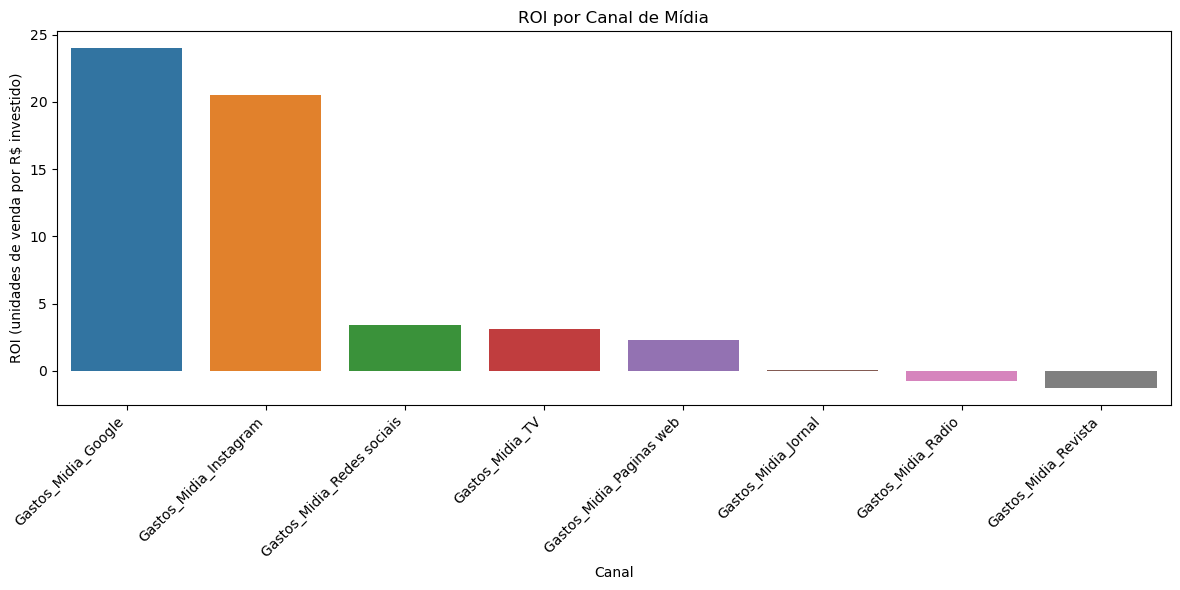

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.barplot(x='Canal', y='ROI', data=roi_df)
plt.title('ROI por Canal de Mídia')
plt.xticks(rotation=45, ha='right')
plt.ylabel('ROI (unidades de venda por R$ investido)')
plt.tight_layout()
plt.show()

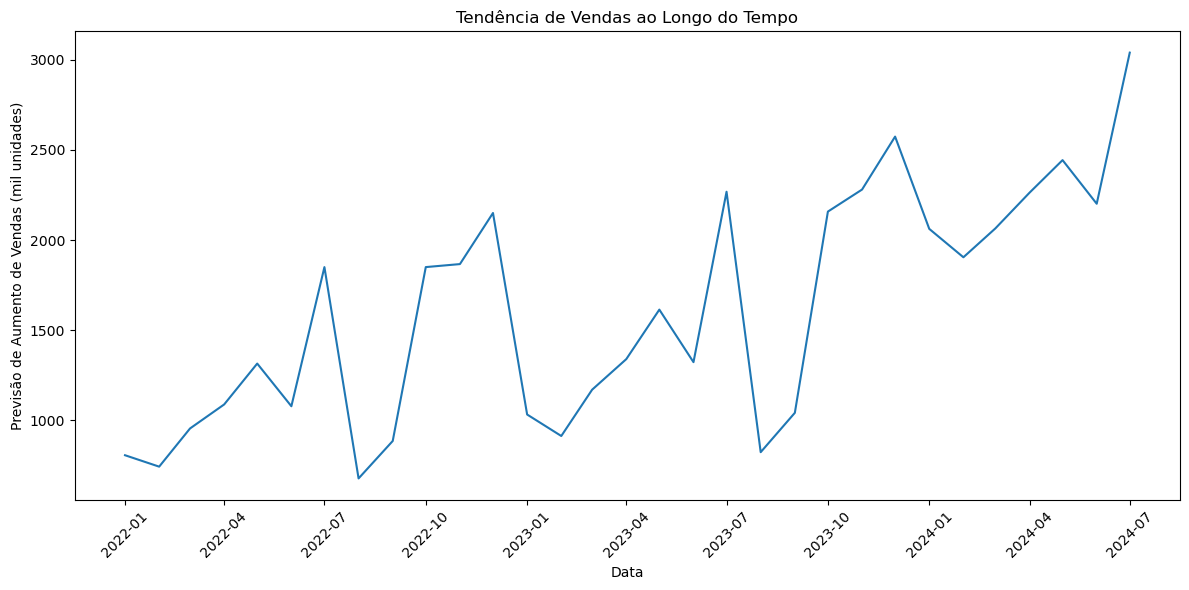

In [9]:
df['Data'] = pd.to_datetime(df['Ano'].astype(str) + '-' + df['Mes'].astype(str).str.zfill(2) + '-01')
df_monthly = df.groupby('Data')['Previsao Inicial de Aumento de Vendas (em mil unidades)'].mean().reset_index()

plt.figure(figsize=(12, 6))
plt.plot(df_monthly['Data'], df_monthly['Previsao Inicial de Aumento de Vendas (em mil unidades)'])
plt.title('Tendência de Vendas ao Longo do Tempo')
plt.xlabel('Data')
plt.ylabel('Previsão de Aumento de Vendas (mil unidades)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

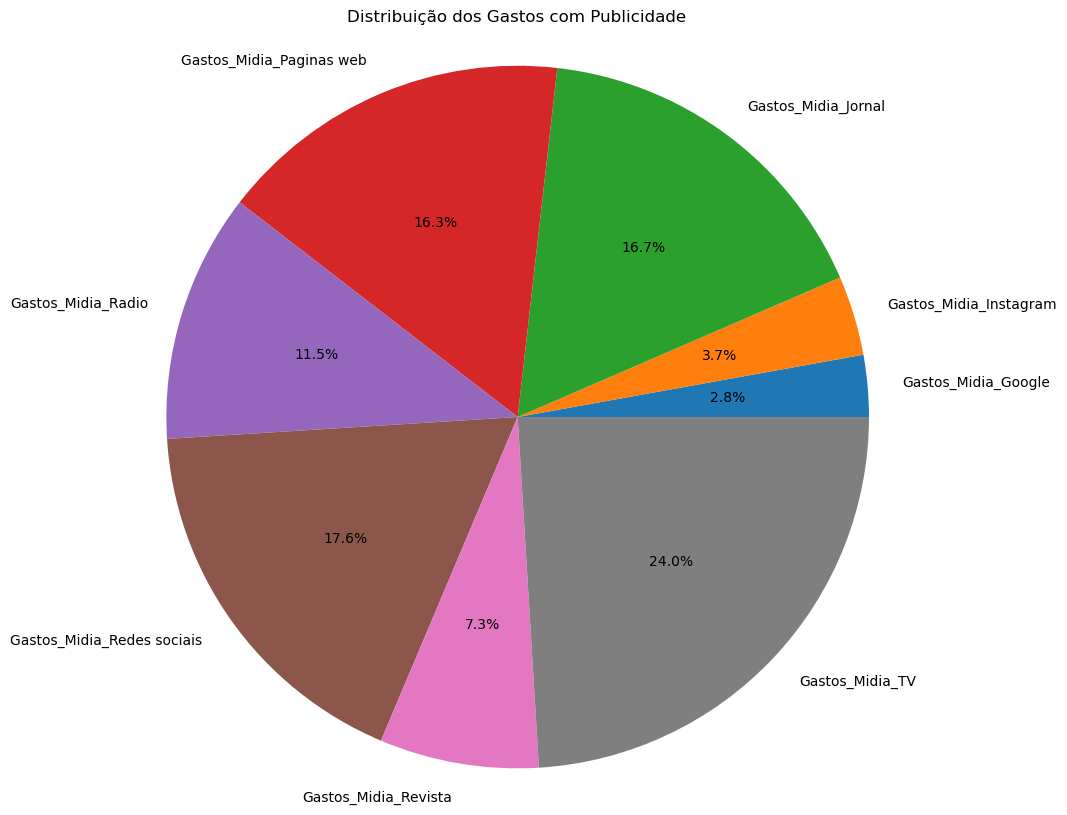

In [10]:
gastos_total = df[['Gastos_Midia_Google', 'Gastos_Midia_Instagram', 'Gastos_Midia_Jornal', 
                   'Gastos_Midia_Paginas web', 'Gastos_Midia_Radio', 'Gastos_Midia_Redes sociais', 
                   'Gastos_Midia_Revista', 'Gastos_Midia_TV']].sum()

plt.figure(figsize=(10, 10))
plt.pie(gastos_total, labels=gastos_total.index, autopct='%1.1f%%')
plt.title('Distribuição dos Gastos com Publicidade')
plt.axis('equal')
plt.show()

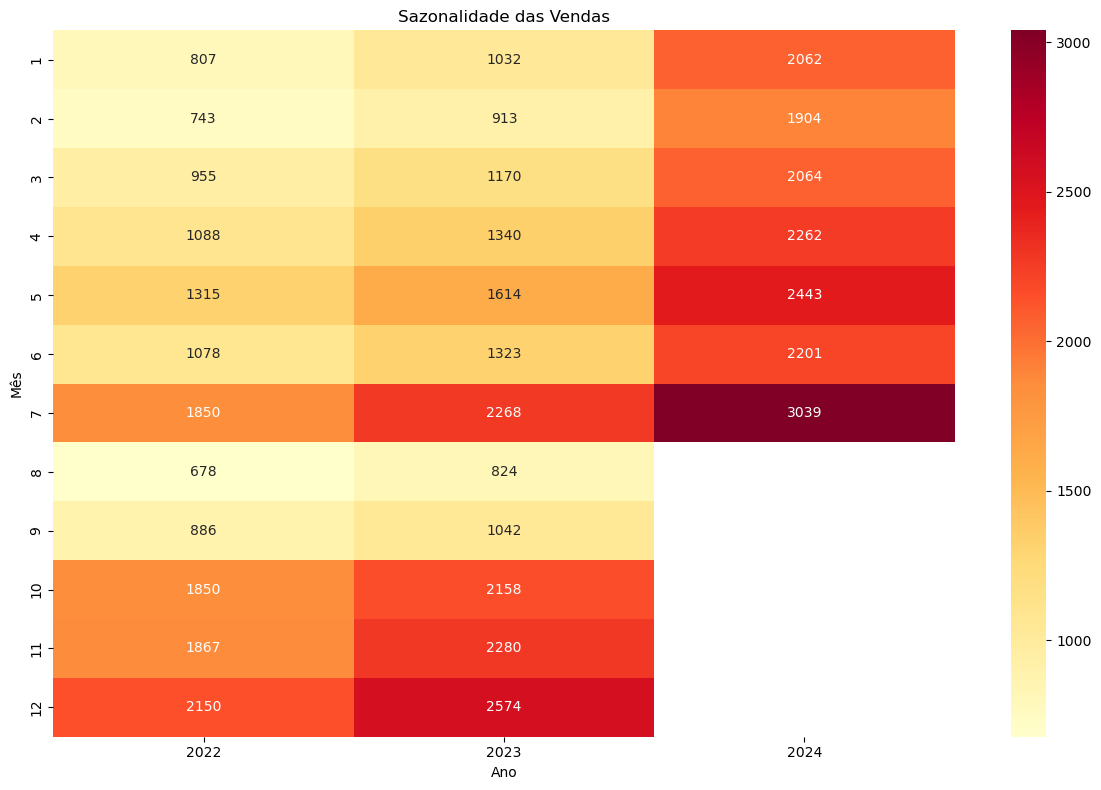

In [11]:
df_pivot = df.pivot_table(values='Previsao Inicial de Aumento de Vendas (em mil unidades)', 
                          index='Mes', columns='Ano', aggfunc='mean')

plt.figure(figsize=(12, 8))
sns.heatmap(df_pivot, annot=True, fmt='.0f', cmap='YlOrRd')
plt.title('Sazonalidade das Vendas')
plt.xlabel('Ano')
plt.ylabel('Mês')
plt.tight_layout()
plt.show()

In [ ]:
"""
Regressão Linear Múltipla:

O cerne deste projeto é a Regressão Linear Múltipla, um método estatístico usado para modelar a relação entre uma variável dependente (neste caso, o aumento nas vendas) e múltiplas variáveis independentes (os gastos em diferentes canais de mídia).
A equação geral da regressão linear múltipla é:
Y = β₀ + β₁X₁ + β₂X₂ + ... + βₚXₚ + ε
Onde:

Y é a variável dependente (aumento nas vendas)
X₁, X₂, ..., Xₚ são as variáveis independentes (gastos em diferentes canais)
β₀ é o intercepto
β₁, β₂, ..., βₚ são os coeficientes de regressão
ε é o termo de erro

O objetivo é estimar os coeficientes β que minimizam a soma dos quadrados dos resíduos (diferenças entre os valores observados e previstos).

Preparação dos Dados:

a) Variáveis Dummy: Transformamos a variável categórica 'Tipo de Mídia' em variáveis dummy. Isso é necessário porque a regressão linear trabalha apenas com variáveis numéricas. Cada tipo de mídia se torna uma coluna binária (0 ou 1).
b) Engenharia de Features: Criamos novas variáveis multiplicando as variáveis dummy pelos gastos, permitindo analisar o impacto específico de cada canal.

Análise Exploratória de Dados (EDA):

a) Matriz de Correlação: Mostra a força e a direção das relações lineares entre todas as variáveis. Valores próximos a 1 ou -1 indicam forte correlação positiva ou negativa, respectivamente.
b) Gráficos de Dispersão: Visualizam a relação entre duas variáveis contínuas. Ajudam a identificar padrões, outliers e a natureza da relação (linear, não-linear).

Modelagem:

Usamos a biblioteca scikit-learn para criar o modelo de regressão linear. O processo envolve:
a) Divisão dos dados: Separamos os dados em conjuntos de treino e teste para avaliar o desempenho do modelo em dados não vistos.
b) Treinamento do modelo: O modelo aprende os coeficientes que melhor se ajustam aos dados de treinamento.
c) Avaliação do modelo: Usamos o R² (coeficiente de determinação) para medir a qualidade do ajuste. R² varia de 0 a 1, onde 1 indica um ajuste perfeito.

Interpretação dos Resultados:

a) Coeficientes: Cada coeficiente representa a mudança esperada na variável dependente para cada unidade de mudança na variável independente correspondente, mantendo todas as outras variáveis constantes.
b) Valor-p: Indica a significância estatística de cada variável. Geralmente, um valor-p < 0.05 é considerado estatisticamente significativo.
c) R²: Nosso modelo alcançou um R² de 0.8404, indicando que explica 84.04% da variância na variável dependente.

Cálculo do ROI:

Calculamos o Retorno sobre Investimento (ROI) para cada canal de mídia. O ROI é uma métrica crucial em marketing, indicando a eficácia de cada investimento em termos de aumento nas vendas.
ROI = (Ganho do Investimento - Custo do Investimento) / Custo do Investimento
No nosso caso, interpretamos o coeficiente de cada variável como o "ganho" por unidade de investimento.

Visualizações Adicionais:

a) Gráfico de Barras do ROI: Permite uma comparação visual rápida da eficácia de diferentes canais.
b) Gráfico de Tendência: Mostra como as vendas evoluíram ao longo do tempo, revelando padrões sazonais ou tendências de longo prazo.
c) Gráfico de Pizza: Ilustra a distribuição dos gastos entre diferentes canais de mídia.
d) Heatmap de Sazonalidade: Revela padrões sazonais nas vendas, o que é crucial para o planejamento de marketing.
e) Gráfico de Dispersão Interativo: Permite uma exploração mais detalhada da relação entre diferentes variáveis.

Implicações Estatísticas:

a) Multicolinearidade: A alta correlação entre algumas variáveis pode afetar a interpretabilidade dos coeficientes individuais. Isso é comum em dados de marketing, onde diferentes canais podem ter efeitos sinérgicos.
b) Heterocedasticidade: A variância dos resíduos pode não ser constante, o que pode afetar a confiabilidade dos intervalos de confiança e testes de hipóteses.
c) Não-linearidade: Assumimos relações lineares, mas na realidade, podem existir relações não-lineares que nosso modelo não captura.

Limitações e Considerações Futuras:

a) Causalidade: Correlação não implica causalidade. Outros fatores não incluídos no modelo podem estar influenciando as vendas.
b) Dados Históricos: O modelo se baseia em dados passados e pode não capturar mudanças futuras no comportamento do consumidor ou no cenário de mídia.
c) Interações entre Canais: Nosso modelo não considera explicitamente as interações entre diferentes canais de mídia, que podem ser significativas na prática.
Este projeto demonstra a aplicação prática de conceitos estatísticos e de ciência de dados para resolver um problema real de negócios. Ele combina análise exploratória, modelagem preditiva e visualização de dados para fornecer insights acionáveis para a equipe de marketing.
"""